In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import histlite as hl
import csky as cy
import pandas as pd

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
from scipy import stats
import setup

Setting up Analysis for:
GFU_for_2011_2012_2013_2014_2015_2016_2017_2018_2019
Setting up GFU_for_2011_2012_2013_2014_2015_2016_2017_2018_2019...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2011_MC.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2013_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2014_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2015_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2016_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2017_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2018_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/IC86_2019_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/GRL/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p06/GRL/IC86_2012_data.npy ...
Reading /

In [2]:
mpl.rcParams['font.size'] = 20

In [3]:
frbs=setup.load_frbs()

#for all frbs: 
#choose northern FRB: 33 deg dec for FRB121102
wn=np.where(frbs['src']=='FRB121102')
wn=wn[0][0] #want only one of the bursts
    
#choose southern FRB: -35 deg dec for FRB180110
ws=np.where(frbs['src']=='FRB180110')
ws=ws[0][0]

Loading all FRBs from catalogs


In [4]:
#for non-spatial prior, regular frbs
def bg_ts_trials(src, n_trials=10000, frb_name = ' ', print_plot=False):
    tr=cy.get_trial_runner(cy.CONF,src=src)
    
    #running bg trials
    trials=tr.get_many_fits(n_trials)
    bg = cy.dists.Chi2TSD(trials)
    if np.count_nonzero(trials.ts)==0:
        print('no nonzero TS values')
    
    if print_plot==True: 
        fig, ax = plt.subplots(figsize=(9,6))
        h = bg.get_hist(bins=50)
        hl.plot1d(ax, h, crosses=True, label='%i bg trials'%(bg.n_total))

        # compare with the chi2 fit:
        x = h.centers[0][1:] #remove zero TS bin from curve: not fitted here
        norm = h.integrate().values #normalization for chi-sq
        ax.semilogy(x, norm * bg.pdf(x), lw=1, label=r'$\chi^2$[%.2f dof, $\eta$=%.3f]'%(bg.ndof, bg.eta))

        ax.set_xlabel(r'TS')
        ax.set_ylabel(r'$N$')
        if src['t_100'][0]==1.: plt.title(r'BG TS distribution, %s (1d)'%(frb_name))
        else: plt.title(r'BG TS distribution, %s (%is)'%(frb_name,src['t_100'][0]*84600.))
        ax.legend()
        plt.savefig('./plots/%s_bgts_%is.png'%(frb_name,int(src['t_100'][0]*84600.)))
    return bg

In [5]:
def sens_dp(src, beta=0.9, nsigma=5, gamma=2., n_trials=10000, logging=False): 
        #beta is %, nsigma is # of sigma for dp
    bg=bg_ts_trials(src, n_trials)
    tr=cy.get_trial_runner(cy.CONF,src=src,
            inj_conf={'flux':cy.hyp.PowerLawFlux(gamma)})

    #sensitivity
    sens=tr.find_n_sig(bg.median(),0.9, tol=0.03,n_batches=10,n_sig_step=1, logging=logging)
    #discovery potential
    disc = tr.find_n_sig(bg.isf_nsigma(nsigma), beta, tol=0.03,n_batches=10,
                         n_sig_step=1, logging=logging)
    return sens, disc

def pf_plot(src, sens, disc, nsigma=5, gamma=2., frb_name=' ', 
            print_plot=False, show_chisq=True):
    fig, ax = plt.subplots(figsize=(9,6))
    mpl.rcParams['font.size'] = 15
    
    xs = np.linspace(0., max(sens['info']['n_sigs']), 500)
    xs_dp = np.linspace(0., max(disc['info']['n_sigs']), 500)
    
    chi2cdf = lambda n: stats.chi2.cdf(n, *sens['info']['params'])
    chi2cdf_dp = lambda n: stats.chi2.cdf(n, *disc['info']['params'])
    
    plt.errorbar(sens['info']['n_sigs'], sens['info']['CLs'], 
             yerr=sens['info']['sigmas'], label = 'Sensitivity')
    plt.errorbar(disc['info']['n_sigs'],disc['info']['CLs'], 
             yerr=disc['info']['sigmas'], label = r'%i$\sigma$ Discovery potential'%nsigma)
    
    if show_chisq==True:
        plt.plot(xs, chi2cdf(xs), label = 'sensitivity Chi2CDF fit')
        plt.axvline(sens['info']['n_sig_chi2cdf'], ls='--')
        plt.plot(xs_dp, chi2cdf_dp(xs_dp), label = 'DP Chi2CDF fit')
        plt.axvline(disc['info']['n_sig_chi2cdf'], ls='--')
        
    plt.legend(loc=4)
    plt.xlabel(r'$n_{\mathrm{inj}}$')
    plt.ylabel(r'Fraction TS $>$ threshold')
    
    if int(src['t_100'][0]) == 1: 
        plt.title(r'passing fraction, %s (1d) $\gamma$=%.1f'%(frb_name,gamma))
    else: 
        plt.title(r'passing fraction, %s (%is) $\gamma$=%.1f'%(frb_name,src['t_100'][0]*84600., gamma))
    
    if print_plot==False: plt.show()
    else: plt.savefig('./plots/%s_pf_%is_%.1f.png'%(frb_name,int(src['t_100'][0]*84600.),gamma))
    
    print('gamma=%.1f'%gamma)
    print(r'Sensitivity: %.3f +/- %.3f | DP: %.3f +/- %.3f'
          %(sens['n_sig'], sens['n_sig']*sens['n_sig_error'],
            disc['n_sig'], disc['n_sig']*disc['n_sig_error']))

In [6]:
src121102_1000=setup.sources(1000.,frbs['mjd'][wn],frbs['ra_deg'][wn],frbs['dec_deg'][wn])
src121102_1d=setup.sources(84600., frbs['mjd'][wn],frbs['ra_deg'][wn],frbs['dec_deg'][wn])
src180110_1000=setup.sources(1000.,frbs['mjd'][ws],frbs['ra_deg'][ws],frbs['dec_deg'][ws])
src180110_1d=setup.sources(84600.,frbs['mjd'][ws],frbs['ra_deg'][ws],frbs['dec_deg'][ws])

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   


Chi2TSD(10000 trials, eta=0.002, ndof=1.776, median=0.000 (from fit 0.000))

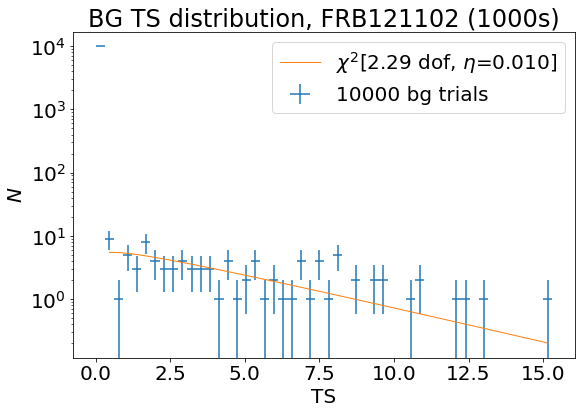

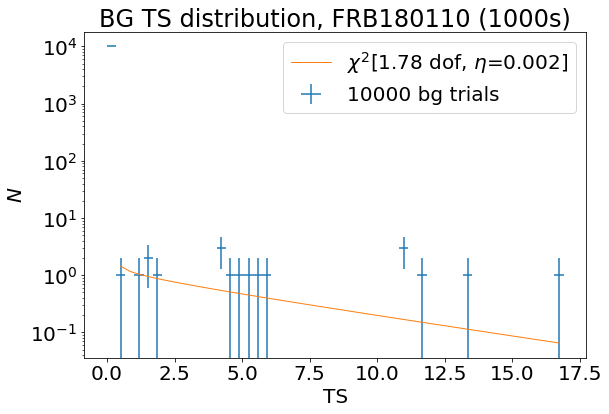

In [51]:
bg_ts_trials(src121102_1000, frb_name='FRB121102', print_plot=True)
bg_ts_trials(src180110_1000, frb_name='FRB180110', print_plot=True)

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   


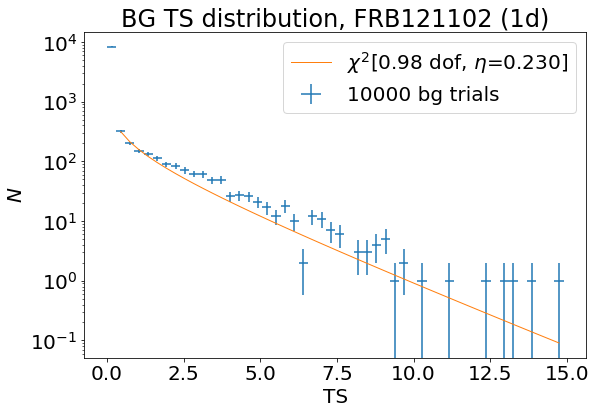

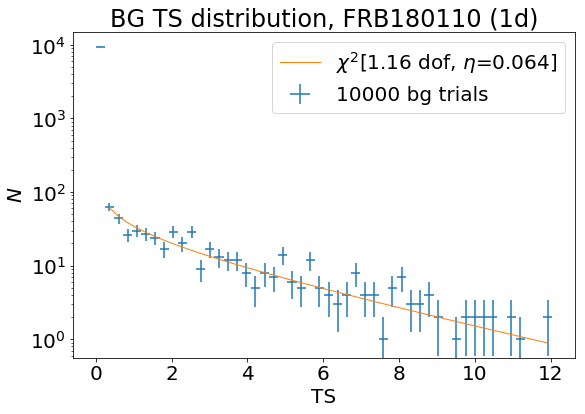

In [52]:
md_n_1d=bg_ts_trials(src121102_1d, frb_name='FRB121102', print_plot=True)
md_s_1d=bg_ts_trials(src180110_1d, frb_name='FRB180110', print_plot=True)

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
gamma=2.0
Sensitivity: 2.369 +/- 0.048 | DP: 7.354 +/- 0.190
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
gamma=2.0
Sensitivity: 2.460 +/- 0.064 | DP: 7.930 +/- 0.220


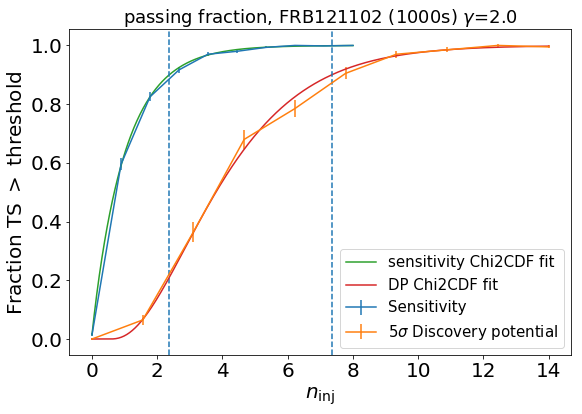

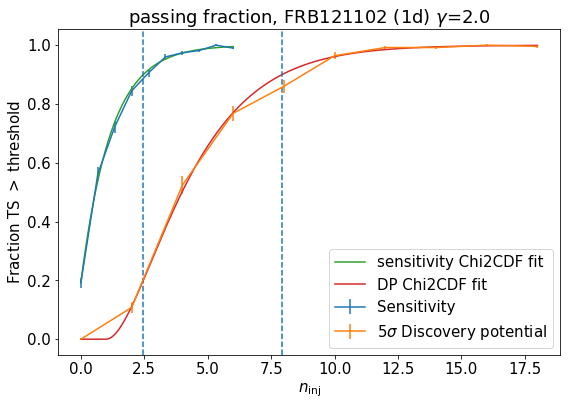

In [53]:
sens,dp = sens_dp(src121102_1000)
pf_plot(src121102_1000,sens, dp, frb_name='FRB121102', print_plot=True)

sens,dp = sens_dp(src121102_1d)
pf_plot(src121102_1d,sens, dp, frb_name='FRB121102', print_plot=True)

#sens,dp = sens_dp(src121102_1000, gamma=2.5)
#pf_plot(src121102_1000,sens, dp, gamma=2.5, frb_name='FRB121102', print_plot=True)

#sens,dp = sens_dp(src121102_1d, gamma=2.5)
#pf_plot(src121102_1d,sens, dp, gamma=2.5, frb_name='FRB121102', print_plot=True)

#sens,dp = sens_dp(src121102_1000, gamma=3.)
#pf_plot(src121102_1000,sens, dp, gamma=3., frb_name='FRB121102', print_plot=True)

#sens,dp = sens_dp(src121102_1d, gamma=3.)
#pf_plot(src121102_1d,sens, dp, gamma=3., frb_name='FRB121102', print_plot=True)

Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
gamma=2.0
Sensitivity: 2.302 +/- 0.068 | DP: 5.384 +/- 0.155
Performing 10000 background trials using 1 core:
      10000/10000 trials complete.   
gamma=2.0
Sensitivity: 2.205 +/- 0.055 | DP: 7.258 +/- 0.206


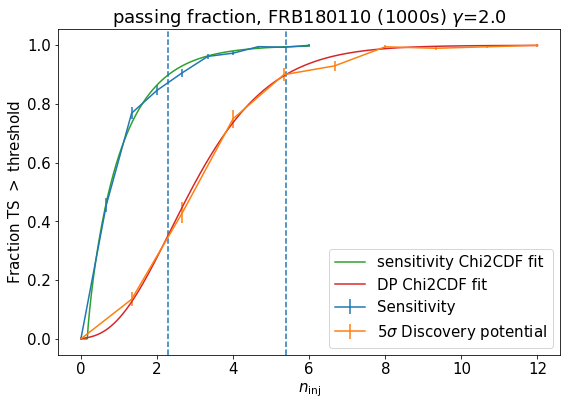

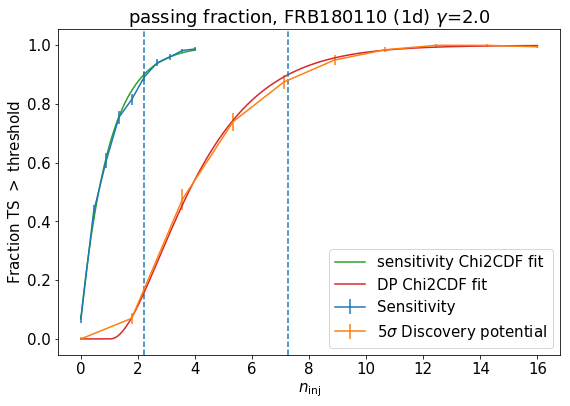

In [54]:
sens,dp = sens_dp(src180110_1000)
pf_plot(src180110_1000,sens, dp, frb_name='FRB180110', print_plot=True)

sens,dp = sens_dp(src180110_1d)
pf_plot(src180110_1d,sens, dp, frb_name='FRB180110', print_plot=True)

#sens,dp = sens_dp(src180110_1000, gamma=2.5)
#pf_plot(src180110_1000,sens, dp, gamma=2.5, frb_name='FRB180110', print_plot=True)

#sens,dp = sens_dp(src180110_1d, gamma=2.5)
#pf_plot(src180110_1d,sens, dp, gamma=2.5, frb_name='FRB180110', print_plot=True)

#sens,dp = sens_dp(src180110_1000, gamma=3.)
#pf_plot(src180110_1000,sens, dp, gamma=3., frb_name='FRB180110', print_plot=True)

#sens,dp = sens_dp(src180110_1d,gamma=3.)
#pf_plot(src180110_1d,sens, dp, gamma=3., frb_name='FRB180110', print_plot=True)

### Fit bias test

In [7]:
def bias_test(src, gamma=2., nsig_max=100, frb_name=' ', print_plot=True):
    n_sigs = np.r_[:nsig_max+1:5]
    tr=cy.get_trial_runner(cy.CONF,src=src,inj_conf={'flux':cy.hyp.PowerLawFlux(gamma)})
    trials = [tr.get_many_fits(100, n_sig=n_sig, logging=False, seed=n_sig) for n_sig in n_sigs]
    
    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))
    allt = cy.utils.Arrays.concatenate(trials)
    
    fig, axs = plt.subplots(1, 2, figsize=(14,6))

    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=2)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    ax = axs[0]
    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')

    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')

    ax = axs[1]
    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, drawstyle='default')
    ax.axhline(expect_gamma, **expect_kw)
    ax.set_xlim(axs[0].get_xlim())

    for ax in axs:
        ax.set_xlabel(r'$n_{inj}$')
        ax.grid()
        if int(src['t_100'][0]) == 1: 
            ax.set_title(r'%s (1d), $\gamma$=%.1f'%(frb_name,gamma))
        else: 
            ax.set_title(r'%s (%is), $\gamma$=%.1f'%(frb_name,src['t_100'][0]*84600., gamma))
        
    axs[0].set_ylabel(r'$n_s$')
    axs[1].set_ylabel(r'$\gamma$')

    if print_plot==True: plt.savefig('./plots/nbias_%s_%i_%.1f.png'%(frb_name,int(src['t_100'][0]*84600.),gamma))
    else: plt.tight_layout()

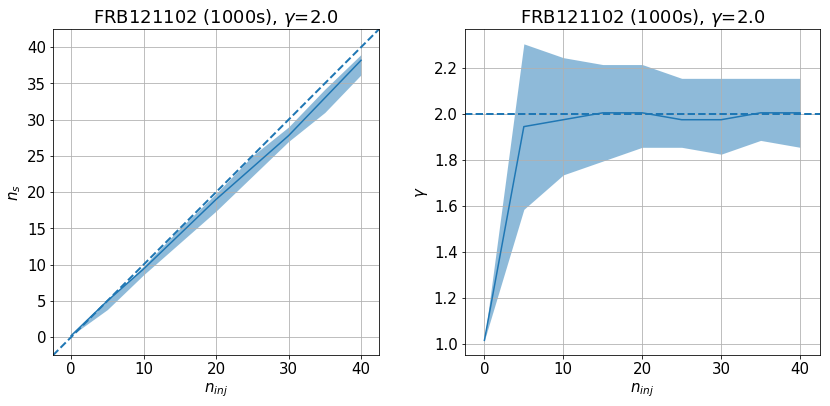

In [59]:
bias_test(src121102_1000,nsig_max=40,frb_name='FRB121102', gamma=2.)
#bias_test(src121102_1000,nsig_max=40,frb_name='FRB121102', gamma=2.5)
#bias_test(src121102_1000,nsig_max=40,frb_name='FRB121102', gamma=3.)

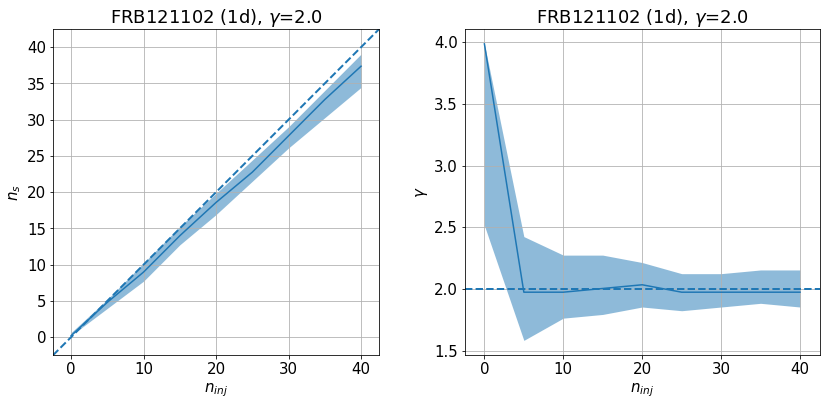

In [60]:
bias_test(src121102_1d,nsig_max=40,frb_name='FRB121102', gamma=2.)
#bias_test(src121102_1d,nsig_max=40,frb_name='FRB121102', gamma=2.5)
#bias_test(src121102_1d,nsig_max=40,frb_name='FRB121102', gamma=3.)

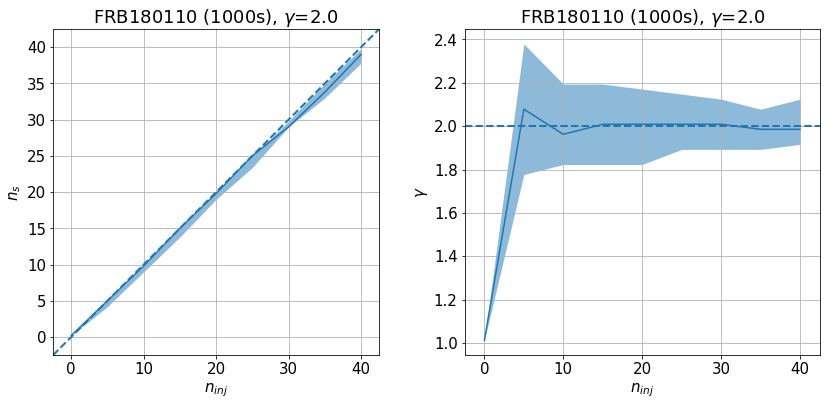

In [61]:
bias_test(src180110_1000,nsig_max=40,frb_name='FRB180110', gamma=2.)
#bias_test(src180110_1000,nsig_max=40,frb_name='FRB180110', gamma=2.5)
#bias_test(src180110_1000,nsig_max=40,frb_name='FRB180110', gamma=3.)

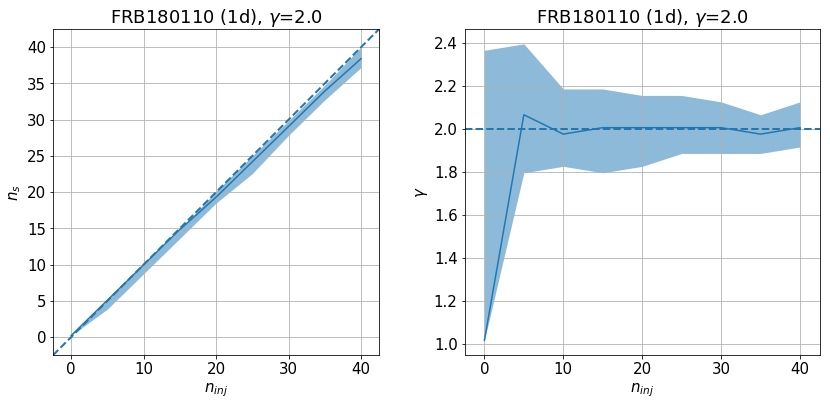

In [62]:
bias_test(src180110_1d,nsig_max=40,frb_name='FRB180110', gamma=2.)
#bias_test(src180110_1d,nsig_max=40,frb_name='FRB180110', gamma=2.5)
#bias_test(src180110_1d,nsig_max=40,frb_name='FRB180110', gamma=3.)

In [63]:
#print(tr.to_E2dNdE(sens, E0=100, unit=1e3))#100 TeV cm^-2 
#print(tr.to_E2dNdE(sens))
#print(tr.to_E2dNdE(sens, E0=1, unit=1))#GeV cm^-2

### Sens/DP at different times

In [8]:
#need to fix so that src_ind=False gives stg meaningful
def sens_dp_dt(t_100,src_ind=False,beta=0.9, nsigma=5, n_trials=50000, logging=True): 
    #beta is %, nsigma is # of sigma for dp
    srcs=setup.sources(t_100, frbs['mjd'][src_ind],frbs['ra_deg'][src_ind],
                       frbs['dec_deg'][src_ind])
    
    tr=cy.get_trial_runner(cy.CONF,src=srcs)
    trials=tr.get_many_fits(n_trials, logging=False)
    if np.count_nonzero(trials.ts)==0: return
    
    bg = cy.dists.Chi2TSD(trials)
    tr=cy.get_trial_runner(cy.CONF,src=srcs,inj_conf={'flux':cy.hyp.PowerLawFlux(2.)})

    sens=tr.find_n_sig(bg.median(),0.9, tol=0.03,n_sig_step=1, logging=False)
    disc = tr.find_n_sig(bg.isf_nsigma(nsigma), beta, tol=0.03,n_sig_step=1, logging=False)
    if logging==True: print("sensitivity: %.3f +/- %.3f | DP: %.3f +/- %.3f"
          %(sens['n_sig'], sens['n_sig']*sens['n_sig_error'], disc['n_sig'], disc['n_sig']*disc['n_sig_error']))
    
    fl=[tr.to_E2dNdE(sens, E0=1, unit=1), tr.to_E2dNdE(disc, E0=1, unit=1)]
    return sens, disc, fl

def deltat_plot(dt_range=[2,6.5],n_points=10, src_ind=False, plt_range=[0.01, 1], 
                logging=True, show_plot=True, frb_name=' ', physunits=False):
    sensit=[]
    sens_err=[]
    dp=[]
    dp_err=[]
    
    ts=np.logspace(dt_range[0],dt_range[1],num=n_points)
    for t_i in ts:
        if logging==True: print('-->t=%i sec'%t_i)
    
        sens,disc,fl= sens_dp_dt(t_i, src_ind=src_ind, logging=logging)
        if physunits==False:
            sensit.append(sens['n_sig'])
            dp.append(disc['n_sig'])
    
            sens_err.append(sens['n_sig_error']*sens['n_sig'])
            dp_err.append(disc['n_sig_error']*disc['n_sig'])
        else: 
            sensit.append(fl[0])
            dp.append(fl[1])
    
            sens_err.append(sens['n_sig_error']*fl[0])
            dp_err.append(disc['n_sig_error']*fl[1])
        
    if show_plot==True: 
        fig,axs = plt.subplots(1,figsize=(9,6))
        axs.errorbar(ts, sensit, yerr=sens_err, label='Sensitivity')
        axs.errorbar(ts, dp, yerr=dp_err, label=r'5$\sigma$ Discovery Potential')
        if physunits==False: axs.set(ylabel=r'$n_{sig}$')
        else: axs.set(ylabel=r'$E^2 \frac{dN}{dE}$ [GeV cm$^{-2}$]')

        axs.semilogx()
        axs.semilogy()
        plt.legend(loc=0)
        if physunits==False: plt.ylim([1,30])
        else: plt.ylim(plt_range)
        axs.set_title(frb_name)

        plt.xlabel('time window (s)')
        if physunits==False: plt.savefig('./plots/%s_deltat.png'%(frb_name))
        else: plt.savefig('./plots/%s_deltat_E2dNdE.png'%(frb_name))
    
    return sensit, sens_err, dp, dp_err

-->t=100 sec
sensitivity: 2.453 +/- 0.072 | DP: 6.379 +/- 0.184
-->t=316 sec
sensitivity: 2.484 +/- 0.062 | DP: 6.067 +/- 0.168
-->t=1000 sec
sensitivity: 2.377 +/- 0.061 | DP: 6.814 +/- 0.193
-->t=3162 sec
sensitivity: 2.505 +/- 0.075 | DP: 6.322 +/- 0.184
-->t=10000 sec
sensitivity: 2.363 +/- 0.070 | DP: 7.521 +/- 0.211
-->t=31622 sec
sensitivity: 2.398 +/- 0.071 | DP: 6.959 +/- 0.182
-->t=100000 sec
sensitivity: 2.475 +/- 0.064 | DP: 8.147 +/- 0.234
-->t=316227 sec
sensitivity: 2.337 +/- 0.069 | DP: 9.141 +/- 0.231
-->t=1000000 sec
sensitivity: 2.473 +/- 0.071 | DP: 10.842 +/- 0.290
-->t=3162277 sec


/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/cvmfs/icecube.opensciencegrid.org/py3-v4.1.0/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


sensitivity: inf +/- nan | DP: 13.518 +/- 0.340


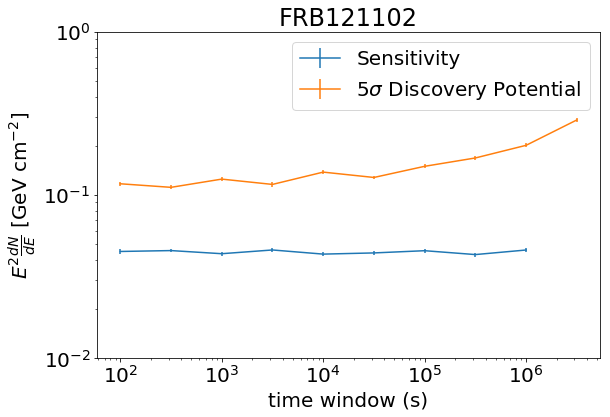

In [9]:
#FRB121102
sens_n, dsens_n, dp_n, ddp_n=deltat_plot(src_ind=wn, frb_name='FRB121102', physunits=True)

-->t=100 sec
sensitivity: 2.287 +/- 0.067 | DP: 4.015 +/- 0.114
-->t=316 sec
sensitivity: 2.312 +/- 0.061 | DP: 4.897 +/- 0.141
-->t=1000 sec
sensitivity: 2.375 +/- 0.069 | DP: 5.835 +/- 0.161
-->t=3162 sec
sensitivity: 3.584 +/- 0.096 | DP: 5.378 +/- 0.146
-->t=10000 sec
sensitivity: 2.471 +/- 0.070 | DP: 6.356 +/- 0.187
-->t=31622 sec
sensitivity: 2.305 +/- 0.067 | DP: 7.193 +/- 0.166
-->t=100000 sec
sensitivity: 2.438 +/- 0.059 | DP: 7.313 +/- 0.187
-->t=316227 sec
sensitivity: 2.324 +/- 0.054 | DP: 8.717 +/- 0.201
-->t=1000000 sec
sensitivity: 2.344 +/- 0.067 | DP: 8.944 +/- 0.231
-->t=3162277 sec
sensitivity: 2.349 +/- 0.058 | DP: 10.125 +/- 0.264


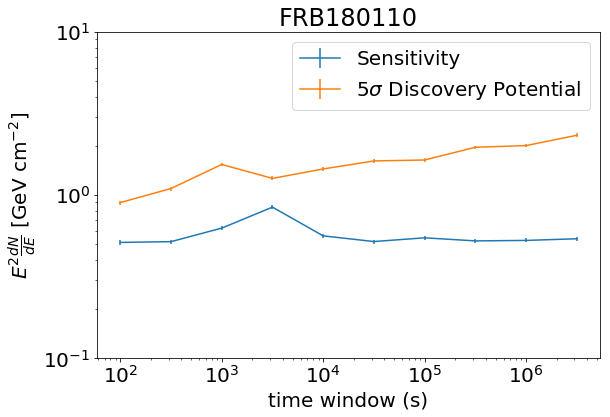

In [10]:
#FRB180110
sens_s, dsens_s, dp_s, ddp_s=deltat_plot(src_ind=ws, frb_name='FRB180110', 
                                         physunits=True, plt_range=[0.1, 10])

#### comparing to Sam's stacking sensitivities

In [ ]:
sens_n=[2.407,2.503,2.490,2.477,2.281,2.362,2.396,2.377,2.598,2.590]
dsens_n=[0.067,0.065,0.063,0.070,0.067,0.061,0.070,0.065,0.071,0.066]
sens_s=[2.284,2.395,2.399,2.411,2.282,2.357,2.437,2.253,2.463,2.358]
dsens_s=[0.068,0.059,0.069,0.069,0.066,0.057,0.071,0.060,0.064,0.060]
ts=np.logspace(2,6.5,num=10)

sam_stacking_sensn=[[85.23131992486864, 171.30387637357418,344.2985288328314,674.8378150323207,
                    1356.336306189001,2725.134963172394,5474.380380461454,11028.955416698205,
                    22245.875832755617,43832.64139616288,88607.50959817678,],
                   [0.002144306375954767,0.0021076411057576157,0.002071602771176431,0.0020046488556250074,
                    0.001970371574744763,0.0018769506271065005, 0.0017601716014638057,0.0021542722610143603,
                    0.002942144827673301, 0.004626739511444778,0.007745896848691351]]
sam_stacking_senss=[[80.50394713946314,164.46234636450697,327.51821400293375,652.2354987318914,
                     1298.893092407461,2586.6780768357526,5151.234934032425,10258.416609018532,
                     20957.02540623357,40683.49759739709,83112.73808216579],
                    [0.01501310728908175,0.01501310728908175,0.014811131413811037,0.014811131413811037,
                     0.014611872781107494,0.014611872781107494,0.014811131413811037,0.014415294835084637,
                     0.014611872781107494,0.014030037231905748,0.01790363339733194]]
fl_n=[]
dfl_n=[]
fl_s=[]
dfl_s=[]
for i in range(len(ts)):
    srcs=setup.sources(ts[i],frbs['mjd'][wn],frbs['mjd'][wn],frbs['mjd'][wn])
    tr=cy.get_trial_runner(cy.CONF,src=srcs,inj_conf={'flux':cy.hyp.PowerLawFlux(2.)})
    fl_n.append(tr.to_E2dNdE(sens_n[i], E0=1, unit=1))
    dfl_n.append(tr.to_E2dNdE(dsens_n[i], E0=1, unit=1))
        
    srcs=sources(ts[i], index=ws)
    tr=cy.get_trial_runner(cy.CONF,src=srcs,inj_conf={'flux':cy.hyp.PowerLawFlux(2.)})
    fl_s.append(tr.to_E2dNdE(sens_s[i], E0=1, unit=1))
    dfl_s.append(tr.to_E2dNdE(dsens_s[i], E0=1, unit=1))
    
fig,axs = plt.subplots(1,figsize=(10,6))
axs.errorbar(ts, fl_n, yerr=dfl_n, label='Sensitivity, FRB121102')
axs.plot(sam_stacking_sensn[0],sam_stacking_sensn[1], 
         label='Northern stacking sensitivity \n (transient tracks)')
axs.set(ylabel=r'$E^2 \frac{dN}{dE}$ [GeV cm$^{-2}$]')

axs.semilogx()
axs.semilogy()
plt.legend(loc=0)
plt.ylim([0.001,1])

plt.xlabel('time window (s)')
plt.savefig('./plots/%s_deltat_comp.png'%('FRB121102'))
    
fig,axs = plt.subplots(1,figsize=(10,6))
axs.errorbar(ts, fl_s, yerr=dfl_s, label='Sensitivity, FRB180110')
axs.plot(sam_stacking_senss[0],sam_stacking_senss[1], 
         label='Southern stacking sensitivity \n (transient tracks)')
axs.set(ylabel=r'$E^2 \frac{dN}{dE}$ [GeV cm$^{-2}$]')

axs.semilogx()
axs.semilogy()
plt.legend(loc=0)
plt.ylim([0.01,10])

plt.xlabel('time window (s)')
plt.savefig('./plots/%s_deltat_comp.png'%('FRB180110'))

#### From Tutorials: bg sanity check for rate

In [ ]:
ana=cy.CONF['ana']
a = ana[-1]
data, sig = a.data, a.sig #sig=MC info

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
hl.plot1d (ax, a.bg_space_param.h, crosses=True, color='k', label='histogram')
sd = np.linspace (-1, 1, 300)
ax.plot (sd, a.bg_space_param(sindec=sd), label='spline')
ax.set_ylim(0)
ax.set_title('GFU 2011-2018')
ax.set_xlabel(r'$\sin(\delta)$')
ax.set_ylabel(r'probability density')

plt.axvline(np.sin(src180110_1000.dec[0]), ls='--',color='r', label='FRB180110')
plt.axvline(np.sin(src121102_1000.dec[0]), ls='--',color='g', label='FRB121102')
ax.legend(loc=4)
plt.savefig('./plots/spatial_pdf.png')